<a href="https://colab.research.google.com/github/Harsh152003/Deep-Learning/blob/main/cat_n_dog_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
image_dir = Path('/content/drive/MyDrive/Cat and Dog Dataset/Dog and Cat .png')

In [3]:
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [4]:
image_df

,Filepath,Label
0,/content/drive/MyDrive/Cat and Dog Dataset/Dog...,Cat
1,/content/drive/MyDrive/Cat and Dog Dataset/Dog...,Cat
2,/content/drive/MyDrive/Cat and Dog Dataset/Dog...,Cat
3,/content/drive/MyDrive/Cat and Dog Dataset/Dog...,Cat
4,/content/drive/MyDrive/Cat and Dog Dataset/Dog...,Cat
...,...,...
994,/content/drive/MyDrive/Cat and Dog Dataset/Dog...,Dog
995,/content/drive/MyDrive/Cat and Dog Dataset/Dog...,Dog
996,/content/drive/MyDrive/Cat and Dog Dataset/Dog...,Dog
997,/content/drive/MyDrive/Cat and Dog Dataset/Dog...,Dog


In [5]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [6]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)


In [7]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
        batch_size=32,
    shuffle=False
)

Found 560 validated image filenames belonging to 2 classes.
Found 139 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


In [8]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 1/10
18/18 [==============================] - 217s 12s/step - loss: 0.6952 - accuracy: 0.4893 - val_loss: 0.6921 - val_accuracy: 0.5036 - lr: 0.0010
Epoch 2/10
18/18 [==============================] - 34s 2s/step - loss: 0.6921 - accuracy: 0.4982 - val_loss: 0.6904 - val_accuracy: 0.5468 - lr: 0.0010
Epoch 3/10
18/18 [==============================] - 35s 2s/step - loss: 0.6911 - accuracy: 0.5929 - val_loss: 0.6901 - val_accuracy: 0.5036 - lr: 0.0010
Epoch 4/10
18/18 [==============================] - 34s 2s/step - loss: 0.6875 - accuracy: 0.5286 - val_loss: 0.6960 - val_accuracy: 0.5036 - lr: 0.0010
Epoch 5/10
18/18 [==============================] - 35s 2s/step - loss: 0.6852 - accuracy: 0.5750 - val_loss: 0.6856 - val_accuracy: 0.5108 - lr: 0.0010
Epoch 6/10
18/18 [==============================] - 40s 2s/step - loss: 0.6764 - accuracy: 0.5768 - val_loss: 0.6699 - val_accuracy: 0.6187 - lr: 0.0010
Epoch 7/10
18/18 [==============================] - 43s 2s/step - loss: 0.6831 -

In [9]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.65662
Test Accuracy: 62.33%


10/10 [==============================] - 11s 1s/step


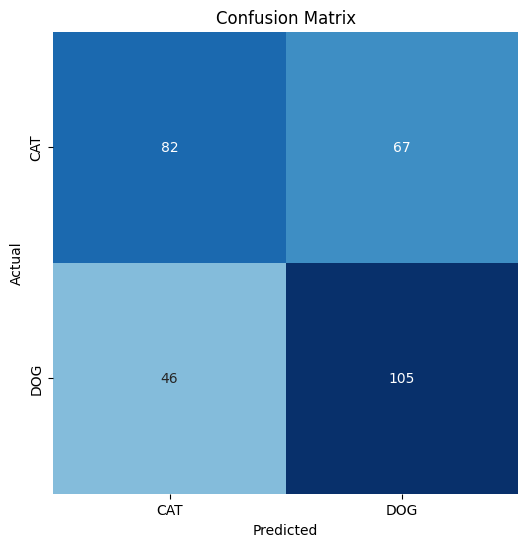

Classification Report:
----------------------
               precision    recall  f1-score   support

         CAT       0.64      0.55      0.59       149
         DOG       0.61      0.70      0.65       151

    accuracy                           0.62       300
   macro avg       0.63      0.62      0.62       300
weighted avg       0.63      0.62      0.62       300



In [11]:
predictions = (model.predict(test_images) >= 0.5)

cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["CAT", "DOG"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.yticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)